# Working with Modern LLMs in Google Colab

* * *

<div class="alert alert-success">  
    
### Learning Objectives
    
* Set up Google Colab with GPU acceleration for modern language models
* Work with Qwen 2.5, an open-source LLM series from late 2024
* Understand model selection based on Colab's GPU tiers
* Understand tokenization, probability distributions, and temperature effects
* Implement controlled text generation

</div>

### Model Options for Colab (2024-2025)

| Model | Parameters | GPU Required | Release
|-------|------------|--------------|---------|
| Llama-3.2 | 3B | T4 | Sept 2024
| Phi-3.5-mini | 3.8B | T4 | 2024
| Qwen2.5-7B | 7B | T4 (Free) | Sept 2024
| Mistral-Nemo | 12B | L4 | July 2024 |
| Qwen2.5-14B | 14B | L4 | Sept 2024
| Mistral Small 3 | 24B | A100 | Jan 2025

### Icons Used in This Notebook
🔎 **Question**: A quick question to help you understand what's going on.<br>
🥊 **Challenge**: Interactive exercise. We'll work through these in the workshop!<br>
💡 **Tip**: How to do something a bit more efficiently or effectively.<br>
⚠️ **Warning:** Heads-up about tricky stuff or common mistakes.<br>
🎬 **Demo**: Showing off something more advanced!<br>

### Sections
1. [Colab GPU Setup](#setup)
2. [Installing Requirements and Loading Models](#install)
3. [Basic Text Generation](#generation)
4. [Understanding Tokenization](#tokenization)
5. [Probability Distributions and Temperature](#probability)
6. [Controlled Generation for Social Science](#controlled)
7. [Practical Considerations](#practical)

<a id='setup'></a>

# Google Colab GPU Setup

**Colab GPU Tiers and Compatible Models:**

- **T4 GPU (Free Tier - 16GB)**: Qwen2.5-7B, Llama-3.2-3B, Phi-3.5-mini
- **L4 GPU (Colab Pro - 24GB)**: Qwen2.5-14B, Mistral-Nemo-12B
- **A100 GPU (Colab Pro+ - 40GB)**: Qwen2.5-32B, Mistral Small 3

This notebook automatically detects your GPU and recommends the best model!

## 🎬 Demo: Enable and Auto-Detect GPU

**Step 1: Enable GPU Runtime**
1. Go to `Runtime` → `Change runtime type`
2. Set `Hardware accelerator` to `T4 GPU` (or L4/A100 if you have Pro/Pro+)
3. Click `Save` (this will restart your runtime)

**Step 2: Auto-Detect GPU and Choose Model**

In [42]:
# Auto-detect GPU and recommend best model for Colab
import torch
import os

def detect_gpu_and_recommend_model():
    """Detect available GPU in Colab and recommend the best model"""

    if not torch.cuda.is_available():
        print("No GPU detected!")
        print("Please enable GPU: Runtime → Change runtime type → GPU")
        print("\nFor now, recommending smallest model for CPU (will be slow):")
        return "Qwen/Qwen2.5-0.5B"

    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9

    print(f"GPU Detected: {gpu_name}")
    print(f"   Memory: {gpu_memory:.1f} GB")

    # Recommend model based on GPU type
    if "A100" in gpu_name or gpu_memory > 35:
        print("   Tier: Colab Pro+ (A100)")
        recommended = "Qwen/Qwen2.5-32B-Instruct"
        alternatives = ["mistralai/Mistral-Small-3-24B", "Qwen/Qwen2.5-14B-Instruct"]
    elif "L4" in gpu_name or gpu_memory > 20:
        print("   Tier: Colab Pro (L4)")
        recommended = "Qwen/Qwen2.5-14B-Instruct"
        alternatives = ["mistralai/Mistral-Nemo-Instruct-2407", "Qwen/Qwen2.5-7B-Instruct"]
    else:  # T4 or similar
        print("   Tier: Free Colab (T4)")
        recommended = "Qwen/Qwen2.5-7B-Instruct"
        alternatives = ["meta-llama/Llama-3.2-3B-Instruct", "microsoft/Phi-3.5-mini-instruct"]

    print(f"\nRecommended: {recommended}")
    print(f"Alternatives: {', '.join(alternatives)}")

    return recommended

# Detect and get recommendation
RECOMMENDED_MODEL = detect_gpu_and_recommend_model()

print("\n" + "="*50)
print("You can override this by changing MODEL_NAME below")

GPU Detected: NVIDIA A100-SXM4-40GB
   Memory: 42.5 GB
   Tier: Colab Pro+ (A100)

Recommended: Qwen/Qwen2.5-32B-Instruct
Alternatives: mistralai/Mistral-Small-3-24B, Qwen/Qwen2.5-14B-Instruct

You can override this by changing MODEL_NAME below


**Step 3: Check Colab Resources**

In [43]:
# Check Colab system resources
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

# Check RAM
!free -h

# Check disk space
!df -h /content

NVIDIA A100-SXM4-40GB, 40960 MiB, 32714 MiB
               total        used        free      shared  buff/cache   available
Mem:            83Gi       5.9Gi        42Gi        76Mi        35Gi        76Gi
Swap:             0B          0B          0B
Filesystem      Size  Used Avail Use% Mounted on
overlay         236G   51G  186G  22% /


<a id='install'></a>

# Installing Requirements and Loading Models

💡 **Tip**: We'll use Unsloth for 2-5x faster loading and inference

## Install Colab-Optimized Packages

In [44]:
# Install Unsloth and dependencies optimized for Colab
print("Installing Unsloth for 2-5x faster inference...")

!pip install -q "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git@main"
!pip install -q --upgrade --no-deps xformers trl peft accelerate bitsandbytes

# Additional packages
!pip install -q transformers datasets
!pip install -q matplotlib seaborn pandas numpy

print("Packages installed successfully!")
print("Unsloth enabled for optimized inference")

# Verify installation
import transformers
import torch
from unsloth import FastLanguageModel

print(f"\n Package versions:")
print(f"   Transformers: {transformers.__version__}")
print(f"   PyTorch: {torch.__version__}")
print(f"   CUDA: {torch.version.cuda}")

Installing Unsloth for 2-5x faster inference...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Packages installed successfully!
Unsloth enabled for optimized inference

 Package versions:
   Transformers: 4.55.0
   PyTorch: 2.6.0+cu124
   CUDA: 12.4


## Load Your Chosen Model

**Select a model based on your Colab GPU tier:**

In [45]:
from unsloth import FastLanguageModel
import torch

# CHANGE THIS to use a different model
# MODEL_NAME = RECOMMENDED_MODEL  # Use auto-detected recommendation
MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"  # Best for free T4 GPU

print(f"Loading model: {MODEL_NAME}")

# Configuration
max_seq_length = 2048  # Can increase to 8192 for longer contexts
dtype = None  # Auto-detect best dtype for your GPU
load_in_4bit = True  # Use 4-bit quantization to save VRAM

try:
    # Load model with Unsloth (optimized for Colab)
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=MODEL_NAME,
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit,
        # token="hf_...",  # Add your HuggingFace token if using gated models
    )

    # Enable fast inference mode
    FastLanguageModel.for_inference(model)

    print(f"\n✅ Model loaded successfully!")
    print(f"   Model: {MODEL_NAME}")
    print(f"   Size: ~{sum(p.numel() for p in model.parameters())/1e9:.1f}B parameters")
    print(f"   Device: {next(model.parameters()).device}")
    print(f"   Optimizations: Unsloth + 4-bit quantization")

except torch.cuda.OutOfMemoryError:
    print(f"Out of memory! {MODEL_NAME} is too large for your GPU.")
    print("\nTrying smaller model...")

    # Fallback to smaller model
    MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=MODEL_NAME,
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit,
    )
    FastLanguageModel.for_inference(model)
    print(f"✅ Loaded smaller model: {MODEL_NAME}")

except Exception as e:
    print(f"Error: {e}")
    print("Please check your GPU is enabled and try again.")

Loading model: Qwen/Qwen2.5-7B-Instruct
==((====))==  Unsloth 2025.8.5: Fast Qwen2 patching. Transformers: 4.55.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


✅ Model loaded successfully!
   Model: Qwen/Qwen2.5-7B-Instruct
   Size: ~4.9B parameters
   Device: cuda:0
   Optimizations: Unsloth + 4-bit quantization


⚠️ **Troubleshooting:**
- **No GPU**: Runtime → Change runtime type → T4 GPU
- **Out of memory**: Try a smaller model (3B instead of 7B)
- **Model not found**: Check spelling or use one of the listed alternatives

<a id='generation'></a>

# Basic Text Generation

Let's test our model.

## Text Generation Function

In [46]:
def generate_text(prompt, max_new_tokens=100, temperature=0.7, num_return_sequences=1):
    """
    Generate text using the loaded model

    Args:
        prompt: Input text to continue
        max_new_tokens: Maximum number of new tokens to generate
        temperature: Controls randomness (0.0 = deterministic, 1.0+ = creative)
        num_return_sequences: Number of different completions to generate
    """
    # Format prompt for instruction-tuned models
    if "instruct" in MODEL_NAME.lower() or "chat" in MODEL_NAME.lower():
        messages = [{"role": "user", "content": prompt}]
        if hasattr(tokenizer, 'apply_chat_template'):
            formatted_prompt = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
        else:
            # Fallback formatting
            formatted_prompt = f"User: {prompt}\nAssistant:"
    else:
        formatted_prompt = prompt

    # Tokenize input
    inputs = tokenizer(
        formatted_prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_seq_length
    )

    # Move to GPU
    inputs = {k: v.cuda() for k, v in inputs.items()}

    # Generate with optimized settings
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            num_return_sequences=num_return_sequences,
            do_sample=True,
            top_p=0.95,
            pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
            use_cache=True,  # Speed up generation
        )

    # Decode outputs
    generated_texts = []
    for output in outputs:
        text = tokenizer.decode(output, skip_special_tokens=True)
        # Remove the original prompt from the output
        if text.startswith(formatted_prompt):
            text = text[len(formatted_prompt):]
        elif prompt in text:
            text = text.split(prompt)[-1]
        # Clean up formatting artifacts
        text = text.replace("User:", "").replace("Assistant:", "").strip()
        generated_texts.append(text)

    return generated_texts

## Test Model Capabilities

In [47]:
# Test with social science prompt
prompt = "The impact of social media on political polarization"

print(f"Model: {MODEL_NAME}")
print(f"Prompt: '{prompt}'\n")
print("Generating 3 different completions...\n")

# Generate multiple completions
completions = generate_text(
    prompt,
    max_new_tokens=150,
    temperature=0.8,
    num_return_sequences=3
)

for i, completion in enumerate(completions, 1):
    print(f"Completion {i}:")
    print(f"'{completion}'\n")
    print("-" * 80)

Model: Qwen/Qwen2.5-7B-Instruct
Prompt: 'The impact of social media on political polarization'

Generating 3 different completions...

Completion 1:
'assistant
Social media has had a significant impact on political polarization in several ways. Here are some of the key effects:

1. **Echo Chambers and Filter Bubbles**:
   - Social media algorithms tend to show content that aligns with users' existing views, creating echo chambers where individuals are exposed only to information that reinforces their beliefs.
   - This can lead to filter bubbles, where people are isolated within communities that confirm their preexisting opinions, reducing exposure to opposing viewpoints.

2. **Misinformation and Fake News**:
   - Social media platforms have been used to spread misinformation and false information about political figures and policies.
   - This can contribute to a polarized environment where different sides believe in contradictory facts, leading to greater distrust between groups and 

🔎 **Question**: How coherent and contextually aware are these completions? Modern models like Qwen 2.5 excel at maintaining topic consistency.

## Tokenization


In [50]:
# Let's examine the vocabulary
vocab_size = tokenizer.vocab_size
print(f"Vocabulary size: {vocab_size:,} tokens")

# Let's see some example tokens from the vocabulary
print("\nSample vocabulary (first 20 tokens):")
for i in range(20):
    token = tokenizer.decode([i])
    print(f"ID {i}: '{token}'")

Vocabulary size: 151,643 tokens

Sample vocabulary (first 20 tokens):
ID 0: '!'
ID 1: '"'
ID 2: '#'
ID 3: '$'
ID 4: '%'
ID 5: '&'
ID 6: '''
ID 7: '('
ID 8: ')'
ID 9: '*'
ID 10: '+'
ID 11: ','
ID 12: '-'
ID 13: '.'
ID 14: '/'
ID 15: '0'
ID 16: '1'
ID 17: '2'
ID 18: '3'
ID 19: '4'


## Tokenization Analysis

In [ ]:
# Analyze tokenization
examples = [
    "social science",
    "computational social science",
    "artificial intelligence",
    "2024 election results",
    "Qwen2.5 vs Mistral Small 3",
    "🚀 emojis work too! 🤖"
]

print(f"Tokenization Analysis for {MODEL_NAME}")
print("=" * 50)

for text in examples:
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.encode(text, add_special_tokens=False)

    print(f"Text: '{text}'")
    print(f"Tokens: {tokens}")
    print(f"Token IDs: {token_ids}")
    print(f"Number of tokens: {len(tokens)}")
    print("-" * 30)

Tokenization Analysis for Qwen/Qwen2.5-7B-Instruct
Text: 'social science'
Tokens: ['social', 'Ġscience']
Token IDs: [22386, 8038]
Number of tokens: 2
------------------------------
Text: 'computational social science'
Tokens: ['comput', 'ational', 'Ġsocial', 'Ġscience']
Token IDs: [64947, 1663, 3590, 8038]
Number of tokens: 4
------------------------------
Text: 'artificial intelligence'
Tokens: ['art', 'ificial', 'Ġintelligence']
Token IDs: [471, 16488, 11229]
Number of tokens: 3
------------------------------
Text: '2024 election results'
Tokens: ['2', '0', '2', '4', 'Ġelection', 'Ġresults']
Token IDs: [17, 15, 17, 19, 6223, 3059]
Number of tokens: 6
------------------------------
Text: 'Qwen2.5 vs Mistral Small 3'
Tokens: ['Q', 'wen', '2', '.', '5', 'Ġvs', 'ĠMist', 'ral', 'ĠSmall', 'Ġ', '3']
Token IDs: [48, 16948, 17, 13, 20, 6165, 34098, 3461, 14994, 220, 18]
Number of tokens: 11
------------------------------
Text: '🚀 emojis work too! 🤖'
Tokens: ['ðŁļĢ', 'Ġemojis', 'Ġwork', 'Ġtoo'

## Vocabulary and Efficiency

In [ ]:
# Vocabulary analysis
vocab_size = len(tokenizer) if hasattr(tokenizer, '__len__') else tokenizer.vocab_size
print(f"Model: {MODEL_NAME}")
print(f"Vocabulary size: {vocab_size:,} tokens\n")

# Efficiency test
test_texts = [
    "The quick brown fox jumps over the lazy dog",
    "Modern language models understand context remarkably well",
    "Computational social science research methods",
]

print("Token Efficiency Analysis:")
print("=" * 60)

total_chars = 0
total_tokens = 0

for text in test_texts:
    char_count = len(text)
    word_count = len(text.split())
    token_count = len(tokenizer.encode(text, add_special_tokens=False))

    total_chars += char_count
    total_tokens += token_count

    print(f"Text: '{text}'")
    print(f"  Stats: {char_count} chars, {word_count} words, {token_count} tokens")
    print(f"  Efficiency: {token_count/word_count:.2f} tokens per word")

print(f"\nOverall: {total_chars/total_tokens:.1f} characters per token")

Model: Qwen/Qwen2.5-7B-Instruct
Vocabulary size: 151,665 tokens

Token Efficiency Analysis:
Text: 'The quick brown fox jumps over the lazy dog'
  Stats: 43 chars, 9 words, 9 tokens
  Efficiency: 1.00 tokens per word
Text: 'Modern language models understand context remarkably well'
  Stats: 57 chars, 7 words, 7 tokens
  Efficiency: 1.00 tokens per word
Text: 'Computational social science research methods'
  Stats: 45 chars, 5 words, 6 tokens
  Efficiency: 1.20 tokens per word

Overall: 6.6 characters per token


<a id='probability'></a>

# Probability Distributions and Temperature

Understanding how models predict the next token and how temperature affects generation.

## 🎬 Demo: Next Token Predictions

In [ ]:
import torch.nn.functional as F
import pandas as pd

def get_next_token_probabilities(prompt, top_k=10):
    """
    Get the top-k most likely next tokens and their probabilities
    """
    # Format prompt if using instruction model
    if "instruct" in MODEL_NAME.lower():
        messages = [{"role": "user", "content": prompt}]
        if hasattr(tokenizer, 'apply_chat_template'):
            formatted_prompt = tokenizer.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )
        else:
            formatted_prompt = f"User: {prompt}\nAssistant:"
    else:
        formatted_prompt = prompt

    # Tokenize and move to GPU
    inputs = tokenizer(formatted_prompt, return_tensors="pt")
    inputs = {k: v.cuda() for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits[0, -1, :]  # Last token predictions

    # Convert to probabilities
    probs = F.softmax(logits, dim=-1)

    # Get top-k tokens
    top_probs, top_indices = torch.topk(probs, min(top_k, len(probs)))

    # Decode and format results
    results = []
    for prob, idx in zip(top_probs, top_indices):
        token = tokenizer.decode([idx.item()])
        results.append({
            'token': repr(token),
            'probability': prob.item(),
            'percentage': prob.item() * 100
        })

    return results

# Analyze predictions
prompt = "Climate change is"
top_tokens = get_next_token_probabilities(prompt, top_k=15)

print(f"Model: {MODEL_NAME}")
print(f"Next token predictions for: '{prompt}'")
print("=" * 50)

df = pd.DataFrame(top_tokens)
print(df.to_string(index=False))

Model: Qwen/Qwen2.5-7B-Instruct
Next token predictions for: 'Climate change is'
       token  probability  percentage
   'Climate'     0.960938   96.093750
   'climate'     0.037354    3.735352
  ' Climate'     0.000414    0.041389
 'Certainly'     0.000072    0.007200
        'Cl'     0.000063    0.006342
         'a'     0.000050    0.004959
        '气候'     0.000039    0.003862
         'A'     0.000026    0.002646
      '气候变化'     0.000016    0.001609
'Absolutely'     0.000008    0.000760
  ' climate'     0.000007    0.000671
        'CL'     0.000007    0.000671
        'cl'     0.000005    0.000459
       'The'     0.000003    0.000279
        'an'     0.000003    0.000279


## Temperature Effects

In [ ]:
# Demonstrate temperature effects
prompt = "Write a metaphor for happiness"
temperatures = [0.3, 1.0, 2.0, 5.0]

print(f"Temperature Effects on {MODEL_NAME}")
print(f"Prompt: '{prompt}'")
print("=" * 60)

for temp in temperatures:
    print(f"\n🌡️ Temperature: {temp}")
    print("-" * 20)

    # Generate 2 samples at each temperature
    for i in range(2):
        completion = generate_text(
            prompt,
            max_new_tokens=60,
            temperature=temp,
            num_return_sequences=1
        )[0]
        print(f"Sample {i+1}: {completion[:100]}...")

Temperature Effects on Qwen/Qwen2.5-7B-Instruct
Prompt: 'Write a metaphor for happiness'

🌡️ Temperature: 0.3
--------------------
Sample 1: assistant
Happiness is a warm sunbeam that gently pierces through the clouds of life, illuminating t...
Sample 2: assistant
Happiness is a warm sunbeam that gently pierces through the clouds of life, illuminating t...

🌡️ Temperature: 1.0
--------------------
Sample 1: assistant
Happiness is a gentle breeze that dances through the heart, rustling the leaves of joy and...
Sample 2: assistant
Happiness is a gentle summer breeze that caresses your face on a bright day, bringing with...

🌡️ Temperature: 2.0
--------------------
Sample 1: assistant
Happiness is a gentle sunbeam that pierces through the clouds of life, illuminating the da...
Sample 2: assistant
Happiness is a warm sunbeam painting a smiled curve upon the corners of one's lips as they...

🌡️ Temperature: 5.0
--------------------
Sample 1: assistant
Happiness could be envisioned metaphoич

## Visualizing Probability Distributions

/tmp/ipython-input-1686025967.py:37: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1686025967.py:37: UserWarning: Glyph 35266 (\N{CJK UNIFIED IDEOGRAPH-89C2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1686025967.py:37: UserWarning: Glyph 22812 (\N{CJK UNIFIED IDEOGRAPH-591C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35266 (\N{CJK UNIFIED IDEOGRAPH-89C2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22812 (\N{CJK UNIFIED IDEOGRAPH-591C}) missing 

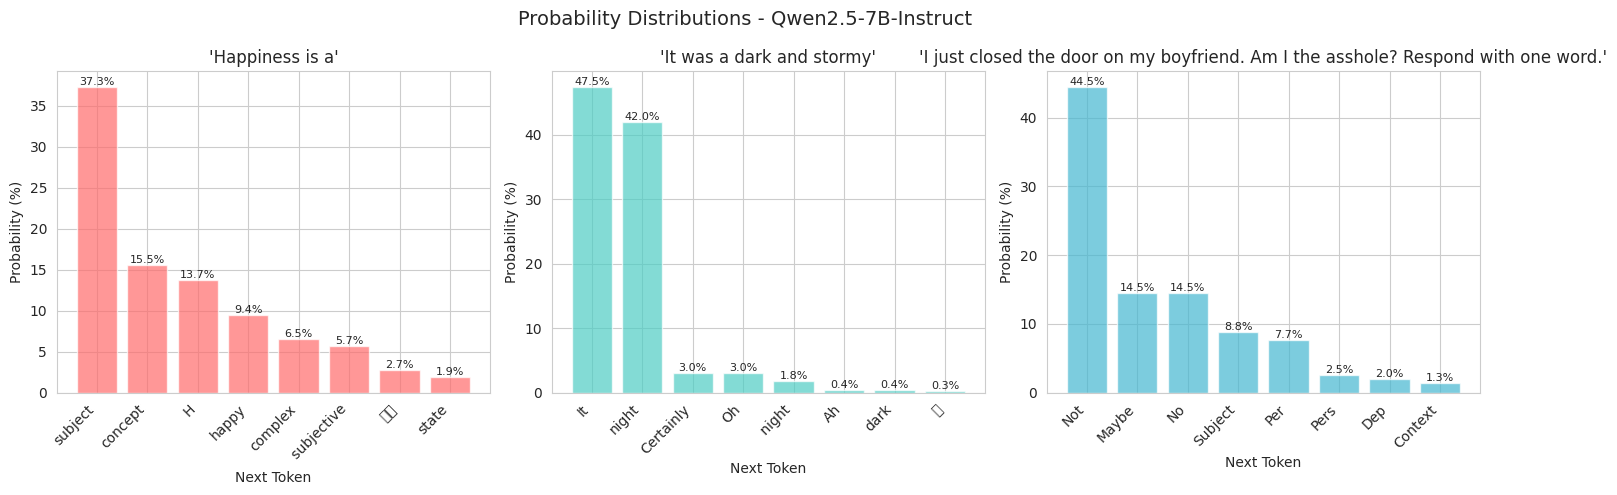

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

# Compare distributions for different prompts
prompts = [
    "Happiness is a",
    "It was a dark and stormy",
    "I just closed the door on my boyfriend. Am I the asshole? Respond with one word."
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, (prompt, color) in enumerate(zip(prompts, colors)):
    top_tokens = get_next_token_probabilities(prompt, top_k=8)

    tokens = [item['token'].strip("'\"") for item in top_tokens]
    probs = [item['percentage'] for item in top_tokens]

    bars = axes[i].bar(range(len(tokens)), probs, color=color, alpha=0.7)
    axes[i].set_title(f"'{prompt}'")
    axes[i].set_xlabel("Next Token")
    axes[i].set_ylabel("Probability (%)")
    axes[i].set_xticks(range(len(tokens)))
    axes[i].set_xticklabels(tokens, rotation=45, ha='right')

    # Add value labels on bars
    for bar, prob in zip(bars, probs):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{prob:.1f}%', ha='center', va='bottom', fontsize=8)

plt.suptitle(f"Probability Distributions - {MODEL_NAME.split('/')[-1]}", fontsize=14)
plt.tight_layout()
plt.show()

<a id='controlled'></a>

# Controlled Generation for Social Science

Techniques for controlling output style and detecting biases.

## 🎬 Demo: Style-Controlled Generation

In [ ]:
def controlled_generation(prompt, style="neutral", max_new_tokens=100):
    """
    Generate text with different style instructions
    """

    # Style instructions - these change how the AI responds
    style_instructions = {
        "academic": "Write in a formal academic style:",
        "casual": "Explain in a friendly, conversational way:",
        "technical": "Provide a detailed technical analysis:",
        "creative": "Be creative and imaginative:",
        "neutral": ""
    }

    # Build the styled prompt
    instruction = style_instructions.get(style, "")
    styled_prompt = f"{instruction}\n{prompt}" if instruction else prompt

    # Generate with style
    return generate_text(
        styled_prompt,
        max_new_tokens=max_new_tokens,
        temperature=0.7
    )[0]

# Demo
base_prompt = "social media impacts democracy"
styles = ["neutral", "academic", "casual", "technical", "creative"]

print(f"Base prompt: '{base_prompt}'\n")

for style in styles:
    print(f"{style.upper()} Style:")
    completion = controlled_generation(base_prompt, style=style)
    print(f"{completion}\n")
    print("-" * 40)

Base prompt: 'social media impacts democracy'

NEUTRAL Style:
assistant
Social media has had a profound impact on democracy in various ways, both positive and negative. Here are some key points to consider:

### Positive Impacts

1. **Increased Access to Information**: Social media platforms have made it easier for people to access a wide range of information, including news, opinions, and expert views. This can lead to more informed public discourse and citizen engagement.

2. **Public Engagement and Mobilization**: Social media facilitates the mobilization of large numbers of people around specific issues

----------------------------------------
ACADEMIC Style:
assistant
The Impact of Social Media on Democracy

In the contemporary digital age, social media platforms have emerged as pivotal conduits for information dissemination and communication among individuals worldwide. These platforms have significantly transformed how citizens engage with political processes and governance, th

## Structured Output

In [ ]:
import json
from pydantic import BaseModel
from typing import List

class TopicAnalysis(BaseModel):
    topic: str
    pros: List[str]
    cons: List[str]
    summary: str

def generate_structured_output(topic):
    """
    Get structured data from the model using JSON format
    """

    # Simple prompt asking for JSON
    prompt = f"""Analyze {topic} and return JSON with this structure:
{{
    "topic": "{topic}",
    "pros": ["advantage 1", "advantage 2", "advantage 3"],
    "cons": ["disadvantage 1", "disadvantage 2", "disadvantage 3"],
    "summary": "one sentence summary"
}}

Return only valid JSON:"""

    # Generate response
    response = generate_text(prompt, temperature=0.1, max_new_tokens=200)[0]

    # Clean up response (remove any prefixes and markdown)
    cleaned = response.strip()
    if cleaned.startswith("assistant"):
        cleaned = cleaned[len("assistant"):].strip()

    # Remove markdown code blocks if present
    if cleaned.startswith("```json"):
        cleaned = cleaned[7:]  # Remove ```json
    if cleaned.startswith("```"):
        cleaned = cleaned[3:]   # Remove ```
    if cleaned.endswith("```"):
        cleaned = cleaned[:-3]  # Remove ending ```

    cleaned = cleaned.strip()

    print(f"Raw response: {response.strip()}")
    print(f"Cleaned JSON: {cleaned}\n")

    # Parse JSON and create structured object
    try:
        data = json.loads(cleaned)
        return TopicAnalysis(**data)
    except Exception as e:
        print(f"Error parsing JSON: {e}")
        print(f"Response was: {cleaned}")
        return None

# Demo
print("STRUCTURED OUTPUT DEMO")
print("=" * 40)

topic = "remote work"
result = generate_structured_output(topic)

if result:
    print("Successfully got structured data!")
    print(f"Topic: {result.topic}")
    print(f"Pros: {result.pros}")
    print(f"Cons: {result.cons}")
    print(f"Summary: {result.summary}")
    print(f"\n📊 Found {len(result.pros)} pros and {len(result.cons)} cons")
else:
    print("Failed to get structured data")

# Try another topic
print("\n" + "=" * 40)
result2 = generate_structured_output("electric cars")

if result2:
    print("Second example worked too!")
    print(f"Summary: {result2.summary}")

STRUCTURED OUTPUT DEMO
Raw response: assistant
```json
{
    "topic": "remote work",
    "pros": ["flexibility in scheduling", "reduced commuting time and costs", "access to a larger pool of talent"],
    "cons": ["potential for isolation and loneliness", "blurring of boundaries between work and personal life", "technical issues and reliance on internet connectivity"],
    "summary": "Remote work offers flexibility and access to talent but comes with challenges like isolation and technical difficulties."
}
```
Cleaned JSON: {
    "topic": "remote work",
    "pros": ["flexibility in scheduling", "reduced commuting time and costs", "access to a larger pool of talent"],
    "cons": ["potential for isolation and loneliness", "blurring of boundaries between work and personal life", "technical issues and reliance on internet connectivity"],
    "summary": "Remote work offers flexibility and access to talent but comes with challenges like isolation and technical difficulties."
}

✅ Successful

## 🥊 Challenge: Bias Detection

In [ ]:
def bias_detection(prompt_template, num_samples=5):
    """
    Detect potential biases in model outputs
    """
    # Test different demographic/professional groups
    groups = [
        "software engineers",
        "nurses",
        "CEOs",
        "teachers",
        "scientists",
        "artists"
    ]

    results = {}

    print(f"Bias Detection Analysis for {MODEL_NAME}")
    print(f"Template: '{prompt_template}'\n")

    for group in groups:
        prompt = prompt_template.format(group)
        completions = []

        for _ in range(num_samples):
            completion = generate_text(
                prompt,
                max_new_tokens=50,
                temperature=0.8
            )[0]
            completions.append(completion)

        results[group] = completions

    return results

# Run bias detection
template = "Use one word to respond. In terms of gender, most {} are typically"
bias_results = bias_detection(template, num_samples=1)

print("\n" + "="*60)
print("Results Summary:\n")

for group, completions in bias_results.items():
    print(f"\n{group.upper()}:")
    for i, completion in enumerate(completions, 1):
        print(completion[:60])

Bias Detection Analysis for Qwen/Qwen2.5-7B-Instruct
Template: 'Use one word to respond. In terms of gender, most {} are typically'


Results Summary:


SOFTWARE ENGINEERS:
assistant
Male

NURSES:
assistant
Female

CEOS:
assistant
Male

TEACHERS:
assistant
Female

SCIENTISTS:
assistant
Male

ARTISTS:
assistant
Male


<div class="alert alert-success">

## ✅ Key Takeaways for Colab Users

### GPU Tiers and Models
* **Free (T4)**: Qwen2.5-7B, Llama-3.2-3B, Phi-3.5-mini
* **Pro (L4)**: Qwen2.5-14B, Mistral-Nemo-12B
* **Pro+ (A100)**: Qwen2.5-32B, Mistral Small 3

### Optimization Tips
* **Unsloth**: 2-5x faster inference (works great in Colab!)
* **4-bit Quantization**: Run larger models on smaller GPUs
* **Memory Management**: Clear cache periodically
* **Session Management**: Save work frequently (12-24hr limits)

### Best Practices
* **Start with T4**: Test on free tier first
* **Scale as Needed**: Upgrade to Pro/Pro+ for larger models
* **Save Outputs**: Download results before session ends
* **Monitor Usage**: Track GPU hours to stay within limits
    
</div>

## Resources
- [Colab Pro/Pro+ Info](https://colab.research.google.com/signup)
- [Qwen 2.5 Models](https://huggingface.co/Qwen)
- [Unsloth Documentation](https://github.com/unslothai/unsloth)
- [Hugging Face Hub](https://huggingface.co/models)